In [4]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('_mpl-gallery')

# 2D Poisson Equation

$$ -\Delta u(x, y) = -\partial^2_{xx} u(x, y) - \partial^2_{yy} u(x, y) = f(x, y) $$

Dirichlet Boundary conditions:

$$ u(0, y) = u(1, y) = u(x, 0) = u(x, 1) = 0 $$

Domain:

$$ [0, 1]\times [0, 1] $$

Assume:

$$ f(x, y) = 1$$

Without BC:

$$ -\frac{1}{2}(x^2 + y^2) $$

## Discretization

In order to construct the numerical scheme, we assume a uniform mesh with grid points:

$$
x_i = ih, \quad y_j = jh, \quad i, j = 0, 1, 2, \dots, N,
$$

where mesh size 

$$h = \frac{1}{N},$$

and

$$x_N = y_N = 1.$$

The solution can be approximated on each grid as,

$$ U_{ij} \approx u(x_i, y_j).$$

In [5]:
n = 50

h = 1 / n

x = np.linspace(0, 1, n + 1)
y = np.linspace(0, 1, n + 1)

x, y, h


(array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 array([0.  , 0.02, 0.04, 0.06, 0.08, 0.1 , 0.12, 0.14, 0.16, 0.18, 0.2 ,
        0.22, 0.24, 0.26, 0.28, 0.3 , 0.32, 0.34, 0.36, 0.38, 0.4 , 0.42,
        0.44, 0.46, 0.48, 0.5 , 0.52, 0.54, 0.56, 0.58, 0.6 , 0.62, 0.64,
        0.66, 0.68, 0.7 , 0.72, 0.74, 0.76, 0.78, 0.8 , 0.82, 0.84, 0.86,
        0.88, 0.9 , 0.92, 0.94, 0.96, 0.98, 1.  ]),
 0.02)

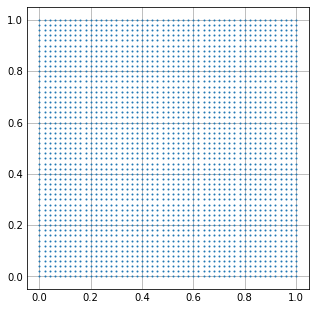

In [6]:
X, Y = np.meshgrid(x, y, indexing="xy")

fig, ax = plt.subplots(figsize=(4, 4))

ax.scatter(X, Y, 1.0)

# X.shape, Y.shape

In [7]:
X[2, 3], Y[2, 3]

(0.06, 0.04)

## Numerical scheme using Finite Difference Method (FDM)

### Central difference

In $x$ direction, we can approximate second order derivative as,

$$ \partial_{xx}^2 u(x_i, y_j) \approx \frac{u'(x_{i+1/2}, y_j) - u'(x_{i-1/2}, y_j)}{h},$$

and then first order derivate can be approximated by

$$ u'(x_{i+1/2}, y_j) \approx \frac{U_{i+1, j} - U_{ij}}{h}.$$

So the central difference scheme is

$$ \partial_{xx}^2 u(x_i, y_j) \approx \frac{U_{i+1, j} - 2U_{ij} + U_{i-1, j}}{h^2}.$$

For $y$ direction we have the same scheme

$$ \partial_{yy}^2 u(x_i, y_j) \approx \frac{U_{i, j+1} - 2U_{ij} + U_{i, j-1}}{h^2}.$$


### FDM scheme (5-points scheme)

$$ - \frac{1}{h^2} (U_{i+1, j} + U_{i, j+1} + U_{i-1, j} + U_{i, j-1} - 4U_{ij}) = f_{ij}, \quad \text{for} \; i, j = 1, 2, \dots, N-1,$$

where $f_{ij} = f(x_i, y_j)$ and with boundary conditions can be written as,

$$ \mathbf{A}\mathbf{U} = \mathbf{F}.$$


* How to flatten $\mathbf{U}$?
* How to construct $\mathbf{A}$?

Two methods:

* Natural order
* Even-odd order


In [8]:
# x shape [51, 51]
n = 50
h = 1 / n


def laplacian(u: np.ndarray) -> np.ndarray:
    """Compute 2D laplace operator."""
    
    # u shape [49, 49]
    x = np.zeros((51, 51))
    x[1:-1, 1:-1] = u
    
    # interior points
    lap_u = (
        -(
            x[:-2, 1:-1] # U_{i-1,j}
            + x[2:, 1:-1] # U_{i+1,j}
            + x[1:-1, :-2] # U_{i,j-1}
            + x[1:-1, 2:] # U_{i,j+1}
            - 4 * x[1:-1, 1:-1]
        )
        / h ** 2
    )
    
    # lap_u shape: [49, 49]
    return lap_u


In [7]:
laplacian(np.ones((49, 49)))


array([[5000., 2500., 2500., ..., 2500., 2500., 5000.],
       [2500.,   -0.,   -0., ...,   -0.,   -0., 2500.],
       [2500.,   -0.,   -0., ...,   -0.,   -0., 2500.],
       ...,
       [2500.,   -0.,   -0., ...,   -0.,   -0., 2500.],
       [2500.,   -0.,   -0., ...,   -0.,   -0., 2500.],
       [5000., 2500., 2500., ..., 2500., 2500., 5000.]])

## Solve the linear system by Jacobi iteration

$$ - \frac{1}{h^2} (U_{i+1, j} + U_{i, j+1} + U_{i-1, j} + U_{i, j-1} - 4U_{ij}) = f_{ij}, \quad \text{for} \; i, j = 1, 2, \dots, N-1,$$

The Jacobi iteration of the system can be written as (at $k$-th step),

$$ U^{(k+1)}_{ij} = \frac{1}{4}(U^{(k)}_{i+1, j} + U^{(k)}_{i, j+1} + U^{(k)}_{i-1, j} + U^{(k)}_{i, j-1} + h^2 f_{ij}).$$

In [9]:
def step_jacobi(u: np.ndarray, f: np.ndarray) -> np.ndarray:
    """Compute one step of Jaccobi iteration."""

    # u shape [49, 49], f shape [49, 49]
    ubc = np.zeros((51, 51))
    ubc[1:-1, 1:-1] = u
    # interior points
    new_u = (
        ubc[:-2, 1:-1] # U_{i-1,j}
        + ubc[2:, 1:-1] # U_{i+1,j}
        + ubc[1:-1, :-2] # U_{i,j-1}
        + ubc[1:-1, 2:] # U_{i,j+1}
        + f * h ** 2
    ) / 4

    return new_u


def jacobi_solver(f: np.ndarray, u0, eps=1e-8, max_steps=100000):

    u = np.ones((n - 1, n - 1))

    for step in range(max_steps):
        u_old = u.copy()
        u = step_jacobi(u, f)

        if np.sqrt(np.sum((u - u_old) ** 2) * h ** 2) < eps:
            return u, step

    print(f"Ending by max_steps: {max_steps}!")

    return u, step


Differente source term

$$
f(x, y) = \sin(\pi x) \sin(\pi y)
$$

In [11]:
f = np.sin(np.pi * x[1:-1]) * np.sin(np.pi * y[1:-1])

In [12]:
F = np.sin(np.pi * X[1:-1, 1:-1]) * np.sin(np.pi * Y[1:-1, 1:-1])
# (49,49) * (49,49) -> (49,49)
F.shape

(49, 49)

In [13]:
# (49,1), (49,) -> (49, 49)

f = np.sin(np.pi * x[1:-1])[:, None] * np.sin(y[1:-1]) + 2.0
f.shape

(49, 49)

In [89]:
np.max(np.abs(f - F))

0.0

In [73]:
a  = np.arange(12).reshape(3,2, 2)
a.shape

(3, 2, 2)

In [79]:
a[..., None, :].shape

(3, 2, 1, 2)

In [77]:
np.newaxis == None

True

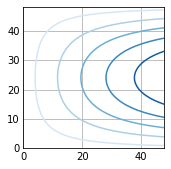

In [98]:
fig, ax = plt.subplots()

ax.contour(f)

In [20]:
%time u, step = jacobi_solver(1.0, np.zeros((n-1, n-1)))


CPU times: user 323 ms, sys: 0 ns, total: 323 ms
Wall time: 319 ms


In [130]:
u, step


(array([[0.0009234 , 0.00164679, 0.00224925, ..., 0.00224925, 0.00164679,
         0.0009234 ],
        [0.00164679, 0.00301452, 0.00418225, ..., 0.00418225, 0.00301452,
         0.00164679],
        [0.00224925, 0.00418225, 0.00586595, ..., 0.00586595, 0.00418225,
         0.00224925],
        ...,
        [0.00224925, 0.00418225, 0.00586595, ..., 0.00586595, 0.00418225,
         0.00224925],
        [0.00164679, 0.00301452, 0.00418225, ..., 0.00418225, 0.00301452,
         0.00164679],
        [0.0009234 , 0.00164679, 0.00224925, ..., 0.00224925, 0.00164679,
         0.0009234 ]]),
 6040)

In [114]:
# i, j
i = 10
j = 20
X[i,j], Y[i, j]

(0.4, 0.2)

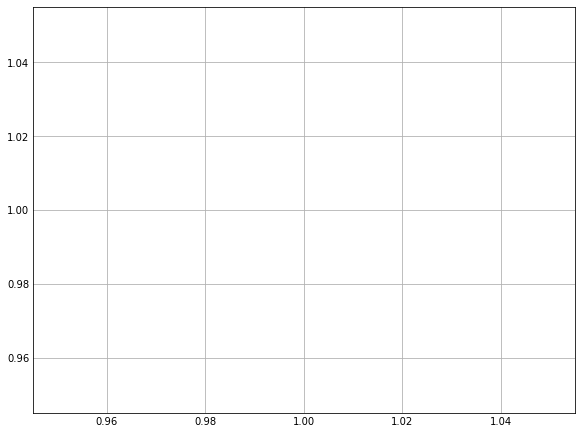

In [121]:
fig, ax = plt.subplots(figsize=(6.4 * 1.2, 4.8 * 1.2))

ubc = np.zeros((51,51))

ubc[1:-1, 1:-1] = u

ax.scatter(np.ones((51,51)), np.ones((51,51)), ubc)
# 
# X.shape, Y.shape

# for i in range(51):
#     for j in range(51):
#         x = X[i, j]
#         y = Y[i, j]
#         u = ubc[i, j]
#         plot_point(x, y, u)
               

## FFT method to solve the system

Assume

$$ U_{ij} = \sum_{m, n=1}^{N-1} \hat{U}_{mn} \sin(\frac{mi\pi}{N}) \sin(\frac{nj\pi}{N}), \quad i,j = 1, 2, \dots, N-1.$$

Then plug into the FDM scheme we have

$$ U_{i+1,j} - 2U_{ij} + U_{i-1, j} = \sum_{m, n=1}^{N-1} \hat{U}_{mn} \left(\sin(\frac{m(i+1)\pi}{N}) - 2\sin(\frac{mi\pi}{N}) + \sin(\frac{m(i-1)\pi}{N})\right)\sin(\frac{nj\pi}{N}) = \sum_{m, n=1}^{N-1} \hat{U}_{mn} \left(\cos(\frac{m\pi}{N}) - 1\right)2\sin(\frac{mi\pi}{N})\sin(\frac{nj\pi}{N}) = -4 \sum_{m, n=1}^{N-1} \hat{U}_{mn} \sin^2(\frac{m\pi}{2N})\sin(\frac{mi\pi}{N})\sin(\frac{nj\pi}{N}) $$

For $y$ direction, we have similar result:

$$ U_{i,j+1} - 2U_{ij} + U_{i, j-1} = -4 \sum_{m, n=1}^{N-1} \hat{U}_{mn} \sin^2(\frac{n\pi}{2N})\sin(\frac{mi\pi}{N})\sin(\frac{nj\pi}{N}) $$

So

$$ - \frac{1}{h^2} (U_{i+1, j} + U_{i, j+1} + U_{i-1, j} + U_{i, j-1} - 4U_{ij}) = -\frac{4}{h^2} \sum_{m, n=1}^{N-1} \hat{U}_{mn} \left(\sin^2(\frac{m\pi}{2N})+\sin^2(\frac{n\pi}{2N})\right)\sin(\frac{mi\pi}{N})\sin(\frac{nj\pi}{N}) = f_{ij} = \sum_{m, n=1}^{N-1} \hat{f}_{mn} \sin(\frac{mi\pi}{N})\sin(\frac{nj\pi}{N}), \quad \text{for} \; i, j = 1, 2, \dots, N-1,$$

and then

$$ \hat{U}_{mn} = \frac{\hat{f}_{mn}}{\frac{4}{h^2} (\sin^2(\frac{m \pi } { 2N }) + \sin^2(\frac{ n \pi}  { 2N })}$$



In [14]:
from scipy.fft import fft, dst


def idst_2d(a):
    return dst(
        dst(a, type=1, axis=1, norm="ortho"), type=1, axis=0, norm="ortho"
    )


def dst_2d(a):
    return dst(
        dst(a, type=1, axis=1, norm="ortho"), type=1, axis=0, norm="ortho"
    )



In [21]:
np.max(np.abs(idst_2d(dst_2d(u)) - u))

5.551115123125783e-17

In [22]:
def preconditioner(f, h, n):
    lambda_ = np.zeros((n - 1, n - 1))
    lambda_[:, :] = 4 * (
        (np.sin(0.5 * np.arange(1, n) * np.pi / n) ** 2 / h ** 2)[:, None]
        + (np.sin(0.5 * np.arange(1, n) * np.pi / n) ** 2 / h ** 2)
    )
    f_hat = dst_2d(f)

    return idst_2d(f_hat / lambda_)


In [23]:
x = np.linspace(0, 1, 49)
y = np.linspace(0, 1, 49)
z = x[:, None] + y

%time sol = preconditioner(np.ones((49, 49)), h, n)


CPU times: user 3.43 ms, sys: 718 µs, total: 4.15 ms
Wall time: 1.91 ms


In [24]:
np.sqrt(np.sum((sol - u) ** 2) * h ** 2)

5.055705777297935e-06

In [25]:
def steepest_descent(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    for _ in range(10000):
        w = lapl(r)
        r_norm = np.sum(r ** 2)
        if np.sqrt(r_norm) < 1e-5:
            break
        alpha = r_norm / (np.sum(r * w) + 1e-8)
        u = u + alpha * r
        r = r - alpha * w
        n_iter += 1

    return u, n_iter


In [27]:
out, n = steepest_descent(laplacian, 2.0)

out, n

(array([[0.00184671, 0.00329342, 0.00449825, ..., 0.00449825, 0.00329342,
         0.00184671],
        [0.00329342, 0.00602872, 0.00836403, ..., 0.00836403, 0.00602872,
         0.00329342],
        [0.00449825, 0.00836403, 0.01173118, ..., 0.01173118, 0.00836403,
         0.00449825],
        ...,
        [0.00449825, 0.00836403, 0.01173118, ..., 0.01173118, 0.00836403,
         0.00449825],
        [0.00329342, 0.00602872, 0.00836403, ..., 0.00836403, 0.00602872,
         0.00329342],
        [0.00184671, 0.00329342, 0.00449825, ..., 0.00449825, 0.00329342,
         0.00184671]]),
 8170)

In [28]:
def CG(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    p = r.copy()
    r_old = np.sum(r ** 2)
    for _ in range(10000):
        w = lapl(p)
        if np.sqrt(r_old) < 1e-5:
            break
        alpha = r_old / (np.sum(p * w) + 1e-8)
        u = u + alpha * p
        r = r - alpha * w
        r_norm = np.sum(r ** 2)
        beta = r_norm / r_old
        p = r + beta * p
        n_iter += 1
        r_old = r_norm

    return u, n_iter


In [32]:
%time out_cg, n_cg = CG(laplacian, 1.0)

out_cg, n_cg

CPU times: user 11.7 ms, sys: 237 µs, total: 11.9 ms
Wall time: 8.85 ms


(array([[0.00092336, 0.00164671, 0.00224913, ..., 0.00224913, 0.00164671,
         0.00092336],
        [0.00164671, 0.00301436, 0.00418201, ..., 0.00418201, 0.00301436,
         0.00164671],
        [0.00224913, 0.00418201, 0.00586559, ..., 0.00586559, 0.00418201,
         0.00224913],
        ...,
        [0.00224913, 0.00418201, 0.00586559, ..., 0.00586559, 0.00418201,
         0.00224913],
        [0.00164671, 0.00301436, 0.00418201, ..., 0.00418201, 0.00301436,
         0.00164671],
        [0.00092336, 0.00164671, 0.00224913, ..., 0.00224913, 0.00164671,
         0.00092336]]),
 83)

In [22]:
n_cg


83

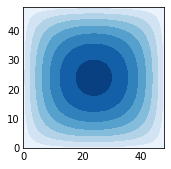

In [33]:
plt.contourf(out_cg)


In [24]:
np.mean((out_cg - sol) ** 2)


1.9936527192698742e-20

In [38]:
def PCG(lapl, f):
    n_iter = 0
    u = np.zeros((49, 49))
    r = f - lapl(u)
    z = preconditioner(r, h, 50)
    p = z.copy()
    for _ in range(10000):
        w = lapl(p)
        r_old = np.sum(r * r)
        alpha = r_old / (np.sum(p * w))
        u = u + alpha * p
        r = r - alpha * w
        if np.sqrt(np.sum(r * r)) < 1e-4:
            break
        z = preconditioner(r, h, n)
        beta = np.sum(z * r) / r_old
        p = z + beta * p
        n_iter += 1

    return u, n_iter


In [39]:
out_pcg, n_pcg = PCG(laplacian, 1.0)


ValueError: operands could not be broadcast together with shapes (49,49) (8169,8169) 